In [1]:
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import tqdm

import os
top = os.getenv('HOME')+'/codes/dispatch2/'
os.chdir(top+'experiments/ISM/python')

import sys
sys.path.insert(0,top+'utilities/python')
import dispatch as dis
import dispatch.select as dse
import dispatch.graphics as dgr
import dispatch.particles as dpa
#from scipy.io import FortranFile as ff
import astropy.units as u
from astropy.constants import M_sun


# Set som plotting standards:
font = {'family' : 'serif',
        'weight' : 'normal',
        'size'   : 16}
mpl.rc('font', **font)

# Mean angular momentum vector
$$\hat{L} = \hat{r} \times \hat{p}$$

In [2]:
# Create directory containing the snapshots
snaps = {}
i_snap = 710; f_snap = 710 + 1
for io in range(i_snap, f_snap):
    sn = dis.snapshot(io,'my_core_13restart')
    snaps[io] = sn
    print(io, sn.time)

710 0.0009760000000000107


In [3]:
sn = snaps[f_snap - 1]
star_pos = sn.sinks[13][0].position; print(star_pos)

[ 0.19190217 -0.43587494  0.28830719]


In [4]:
ds = 0.5**20
w = 100
size = w * ds
extent = size * sn.scaling.l / sn.cgs.au; print(extent,'AU')
cgs_time = sn.scaling.t / sn.cgs.yr
cgs_density = ((sn.scaling.m/sn.cgs.m_sun) / (sn.scaling.l / sn.cgs.au)**3) / (M_sun.to('kg').value / u.au**3).to('cm**(-3)').value; print(cgs_density)
cgs_density = sn.scaling.d / 0.001; print(cgs_density)
print(sn.scaling.d), print( (sn.scaling.m) / (sn.scaling.l)**3 )
print(sn.time *cgs_time)

78.69088076015207 AU
9.03259185467041e-06
3.187e-18
3.187e-21
3.187e-21
21211.7281094472


In [5]:
ρ = dse.amr2raw(sn, center = star_pos, width = w, verbose = 1, lmax = 20, lmin = 15, ivs = 'd')
ux =  dse.amr2raw(sn, center = star_pos, width = w, verbose = 1, lmax = 20, lmin = 15, ivs = 'ux')
uy =  dse.amr2raw(sn, center = star_pos, width = w, verbose = 1, lmax = 20, lmin = 15, ivs = 'uy')
uz =  dse.amr2raw(sn, center = star_pos, width = w, verbose = 1, lmax = 20, lmin = 15, ivs = 'uz')

variable list: ['d']
  7.4s for 1677 patches
writing raw file paraview100.raw
variable list: ['ux']
  7.6s for 1677 patches
writing raw file paraview100.raw
variable list: ['uy']
  7.7s for 1677 patches
writing raw file paraview100.raw
variable list: ['uz']
  7.6s for 1677 patches
writing raw file paraview100.raw


In [6]:
V = np.array([ux, uy, uz])
P = ρ * V; print(P.shape)

x = np.linspace(-extent/2, extent/2, w)
y = np.linspace(-extent/2, extent/2, w)
z = np.linspace(-extent/2, extent/2, w)
XX, YY, ZZ = np.meshgrid(x, y, z, indexing='ij')
r = np.array([XX, YY, ZZ]); print(r.shape)

L = np.cross(r, P, axisa=0, axisb=0, axisc=0)
mean_angMV = np.array([np.mean(L[0]), np.mean(L[1]), np.mean(L[2])])
mean_angMV

(3, 100, 100, 100)
(3, 100, 100, 100)


array([ 1.61345599e+08, -3.87582230e+07,  3.39271660e+07])

In [7]:
mean_angMV /= np.linalg.norm(mean_angMV); print(mean_angMV)
x_vector = [np.array([1, 0, 0])]
y_vector = [np.array([0, 1, 0])]
calc_ang = lambda vector1, vector2: np.rad2deg(np.arccos(np.dot(vector1, vector2) / (np.linalg.norm(vector1) * np.linalg.norm(vector2))))[0]
print(f'Angle between the x-vector and the mean angular momentum vector: {calc_ang(x_vector, mean_angMV):2.1f} deg')

[ 0.95263107 -0.22883975  0.2003158 ]
Angle between the x-vector and the mean angular momentum vector: 17.7 deg


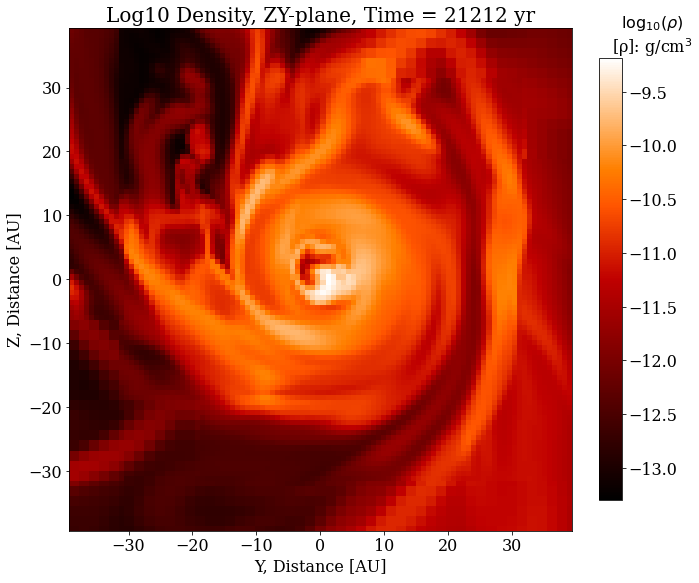

In [8]:
def plot_density(dens_data, axis = 0, width = w):
    
    planes = ['ZY', 'ZX', 'YX']
    ds = 0.5**20
    size = w * ds
    extent = size * sn.scaling.l / sn.cgs.au

    fig, axs = plt.subplots(figsize = (10, 10))
    plot_data_d = np.log10(np.take(dens_data * cgs_density, np.shape(dens_data)[axis] // 2, axis=axis)).transpose()

    cs = axs.imshow(plot_data_d, cmap = 'gist_heat', extent = (-extent/2, extent/2, -extent/2, extent/2), origin = 'lower')
    cbar = fig.colorbar(cs, ax = axs, fraction = 0.04);
    cbar.set_label('$\log_{10}(ρ)$\n[ρ]: g/cm$^3$', labelpad = -25, y = 1.1, rotation = 0, fontsize = 16)

    #axs.quiver(XX, YY, ux[::skip, ::skip, np.shape(ff)[0]//2], uy[::skip, ::skip, np.shape(ff)[0]//2], scale = 200)

    axs.set_title(f'Log10 Density, {planes[axis]}-plane, Time = {sn.time * cgs_time:4.0f} yr', fontsize = 20)
    axs.set_xlabel(f'{planes[axis][-1]}, Distance [AU]', fontsize = 16); axs.set_ylabel(f'{planes[axis][0]}, Distance [AU]', fontsize = 16)

    plt.tight_layout()
plot_density(ρ, axis = 0)


## Calculate mean angular momentum vector through mean of patches

In [9]:
print(sn.time * cgs_time)
star_pos = sn.sinks[13][0].position
dist = lambda dist1, dist2: np.sqrt(np.sum((dist1 - dist2)**2))
cgs_length = sn.scaling.l / sn.cgs.au
distance = 50 / cgs_length

pp = [p for p in sn.patches if dist(p.position, star_pos) < distance]

21211.7281094472


In [10]:
diag_patch = lambda patch: 0.5 * (np.sum(patch.size**2))**0.5

def calc_mean_angvec(snapshot, distance = 100):
    cgs_length = snapshot.scaling.l / snapshot.cgs.au
    d = distance / cgs_length
    
    pp = [p for p in sn.patches if dist(p.position, star_pos) < d]
    L = np.zeros(3)
    for i, p in enumerate(pp):
        r_vector = p.position - star_pos
        patch_mass = p.var('d').mean() * np.prod(p.size)
        V_mean = np.array([p.var('ux').mean(), p.var('uy').mean(), p.var('uz').mean()])
        L += np.cross(r_vector, patch_mass * V_mean)
    return L / np.linalg.norm(L)


Angle between the x-vector and the mean angular momentum vector: 15.6 deg


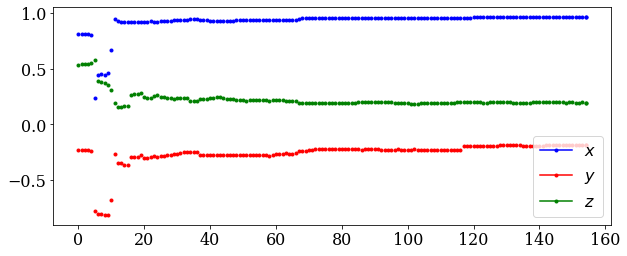

In [11]:
diag_patch = lambda patch: 0.5 * (np.sum(patch.size**2))**0.5
distance = 40
snapshot = sn
cgs_length = snapshot.scaling.l / snapshot.cgs.au
d = distance / cgs_length



fig, axs = plt.subplots(figsize = (10, 4))

pp = [p for p in sn.patches if dist(p.position, star_pos) < d and p.level >= 15]
L = np.zeros(3)
for i, p in enumerate(pp):
    r_vector = p.position - star_pos
    patch_mass = p.var('d').mean() * np.prod(p.size)
    V_mean = np.array([p.var('ux').mean(), p.var('uy').mean(), p.var('uz').mean()])
    L += np.cross(r_vector, patch_mass * V_mean)

    axs.plot(i, L[0] / np.linalg.norm(L), 'blue', marker = '.')
    axs.plot(i, L[1] / np.linalg.norm(L), 'red', marker= '.')
    axs.plot(i, L[2] / np.linalg.norm(L), 'green', marker = '.')

axs.plot(i, L[0] / np.linalg.norm(L), 'blue', marker = '.', label = '$x$')
axs.plot(i, L[1] / np.linalg.norm(L), 'red', marker= '.', label = '$y$')
axs.plot(i, L[2] / np.linalg.norm(L), 'green', marker = '.', label = '$z$')
plt.legend(loc = 'lower right')


print(f'Angle between the x-vector and the mean angular momentum vector: {calc_ang(x_vector, calc_mean_angvec(sn, 40)):2.1f} deg')

In [12]:
for i in range(1, 21):
    for p in sn.patches:
        if p.level == i:
            break
    print(f'Level:{i}, patch longest side:   {(np.max(p.size) * cgs_length):5.0e} au, cell size: {np.max(p.ds) * cgs_length:3.0f} au')

Level:1, patch longest side:   3e+04 au, cell size: 1612 au
Level:2, patch longest side:   3e+04 au, cell size: 1612 au
Level:3, patch longest side:   3e+04 au, cell size: 1612 au
Level:4, patch longest side:   8e+05 au, cell size: 51571 au
Level:5, patch longest side:   4e+05 au, cell size: 25785 au
Level:6, patch longest side:   2e+05 au, cell size: 12893 au
Level:7, patch longest side:   1e+05 au, cell size: 6446 au
Level:8, patch longest side:   5e+04 au, cell size: 3223 au
Level:9, patch longest side:   3e+04 au, cell size: 1612 au
Level:10, patch longest side:   1e+04 au, cell size: 806 au
Level:11, patch longest side:   6e+03 au, cell size: 403 au
Level:12, patch longest side:   3e+03 au, cell size: 201 au
Level:13, patch longest side:   2e+03 au, cell size: 101 au
Level:14, patch longest side:   8e+02 au, cell size:  50 au
Level:15, patch longest side:   4e+02 au, cell size:  25 au
Level:16, patch longest side:   2e+02 au, cell size:  13 au
Level:17, patch longest side:   1e+02

## Making it so I loop over all cells within each patch

### Map the different cells in each patch - already done! patch.x, patch.y, patch.z

335
Patch  6  L: [ 3.06686438e-11 -5.24205628e-12  1.47177003e-11]
Patch  7  L: [ 1.65229070e-11 -5.16180549e-12  7.88429981e-12]
Patch  8  L: [2.21022484e-11 5.32080745e-13 3.16217065e-12]
Patch  9  L: [ 1.66230658e-11 -5.54853829e-12  7.76136250e-12]
Patch  10  L: [2.24208155e-11 4.07300874e-13 2.65851797e-12]
Patch  11  L: [ 1.06756117e-10 -2.64800088e-11  1.86222149e-11]
Patch  13  L: [ 9.08077810e-11 -2.35544687e-11  1.91676676e-11]
Patch  14  L: [ 3.35453526e-11 -6.93243018e-12  4.35254572e-12]
Patch  15  L: [ 1.54622814e-11 -5.27805875e-12  7.17314435e-12]
Patch  16  L: [4.63369920e-16 1.43791750e-15 8.95036784e-16]
Patch  17  L: [-3.19635034e-17 -2.83246249e-16  7.67469175e-17]
Patch  18  L: [ 1.13555605e-11 -4.11091571e-12  5.53314373e-12]
Patch  19  L: [ 1.29924948e-13 -5.04856890e-14  1.44587160e-13]
Patch  20  L: [ 3.26922505e-14 -2.17818107e-14  2.12365099e-14]
Patch  21  L: [ 9.58776820e-15 -6.85841204e-15  7.82531175e-15]
Patch  22  L: [ 1.44733968e-11 -6.68363939e-12  1

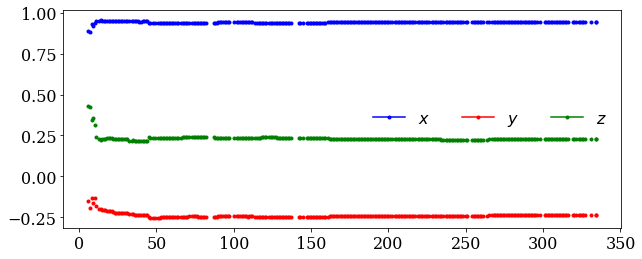

In [13]:
L = np.zeros(3)
fig, axs = plt.subplots(figsize = (10, 4))
distance = 40
cgs_length = sn.scaling.l / sn.cgs.au
d = distance / cgs_length
pp = [p for p in sn.patches if dist(p.position, star_pos) < d + diag_patch(p)]; print(len(pp))
contained=0

for _, p in enumerate(pp):
    #if _ > 6: continue

    XX, YY, ZZ = np.meshgrid(p.xi - star_pos[0], p.yi - star_pos[1], p.zi - star_pos[2], indexing='ij')
    patch_rvector = np.array([XX, YY, ZZ]); 

    patch_velocities = np.asarray([p.var('ux'), p.var('uy'), p.var('uz')])  #Shape: (3, 16, 16, 16)
    patch_mass = np.asarray(p.var('d')) * np.prod(p.ds); 
    patch_dist = np.linalg.norm(patch_rvector, axis = 0) 
    
    # If any part of the patch lies outside of the sphere this part, should not be apart of L
    # Since np.cross does not deal with nan values, I loop over the cells of the pacthes in the edge
    if (patch_dist > d).any():
        if (patch_dist > d).all():
            continue
        
        L_patch = np.zeros(3)
        for i in range(p.ncell[0]):
            for j in range(p.ncell[1]):
                for k in range(p.ncell[2]):
                    r_vector = patch_rvector[:, i, j, k]
                    if np.linalg.norm(r_vector) > d:
                        continue
                    cell_mass = patch_mass[i, j , k]
                    V_cell = patch_velocities[:, i, j, k]
                    L_patch += np.cross(r_vector, cell_mass * V_cell)
        L += L_patch
        print("Patch ",_," L:", L_patch)
    else:
        contained+=1
        patch_momentum = np.copy(patch_velocities)
        for j in range(3):
            patch_momentum[j] *= patch_mass
        L_patch = np.cross(patch_rvector, patch_momentum , axisa=0, axisb=0, axisc=0)
        L_patch = np.array([np.sum(L_patch[0]), np.sum(L_patch[1]), np.sum(L_patch[2])])
        L += L_patch
    axs.plot(_, L[0] / np.linalg.norm(L), 'blue', marker = '.')
    axs.plot(_, L[1] / np.linalg.norm(L), 'red', marker= '.')
    axs.plot(_, L[2] / np.linalg.norm(L), 'green', marker = '.')

axs.plot(_, L[0] / np.linalg.norm(L), 'blue', marker = '.', label = '$x$')
axs.plot(_, L[1] / np.linalg.norm(L), 'red', marker= '.', label = '$y$')
axs.plot(_, L[2] / np.linalg.norm(L), 'green', marker = '.', label = '$z$')

plt.legend(frameon = False, ncol = 3)

print("Completely contained patchess :", contained)
# This cell takes ~29s to run for distance = 100, ~24s for distance = 50
print(f'Angle between the x-vector and the mean angular momentum vector: {calc_ang(x_vector, L):2.1f} deg')

Looping through 335 patches
Patch  6  L: [ 3.06686438e-11 -5.24205628e-12  1.47177003e-11]
Patch  7  L: [ 1.65229070e-11 -5.16180549e-12  7.88429981e-12]
Patch  8  L: [2.21022484e-11 5.32080745e-13 3.16217065e-12]
Patch  9  L: [ 1.66230658e-11 -5.54853829e-12  7.76136250e-12]
Patch  10  L: [2.24208155e-11 4.07300874e-13 2.65851797e-12]
Patch  11  L: [ 1.06756117e-10 -2.64800088e-11  1.86222149e-11]
Patch  13  L: [ 9.08077810e-11 -2.35544687e-11  1.91676676e-11]
Patch  14  L: [ 3.35453526e-11 -6.93243018e-12  4.35254572e-12]
Patch  15  L: [ 1.54622814e-11 -5.27805875e-12  7.17314435e-12]
Patch  16  L: [4.63369920e-16 1.43791750e-15 8.95036784e-16]
Patch  17  L: [-3.19635034e-17 -2.83246249e-16  7.67469175e-17]
Patch  18  L: [ 1.13555605e-11 -4.11091571e-12  5.53314373e-12]
Patch  19  L: [ 1.29924948e-13 -5.04856890e-14  1.44587160e-13]
Patch  20  L: [ 3.26922505e-14 -2.17818107e-14  2.12365099e-14]
Patch  21  L: [ 9.58776820e-15 -6.85841204e-15  7.82531175e-15]
Patch  22  L: [ 1.4473396

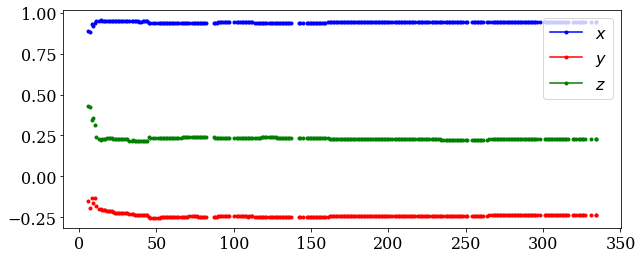

In [14]:
L = np.zeros(3)

fig, axs = plt.subplots(figsize = (10, 4))

distance = 40
patches_skipped = 0
cgs_length = sn.scaling.l / sn.cgs.au
d = distance / cgs_length
pp = [p for p in sn.patches if dist(p.position, star_pos) < d + diag_patch(p)]; print(f'Looping through {len(pp)} patches')
contained = 0

for i, p in enumerate(pp):
    #if i > 6: continue
    XX, YY, ZZ = np.meshgrid(p.xi - star_pos[0], p.yi - star_pos[1], p.zi - star_pos[2], indexing='ij')
    patch_rvector = np.array([XX, YY, ZZ]); 

    patch_velocities = np.asarray([p.var('ux'), p.var('uy'), p.var('uz')])  
    patch_masses = np.asarray(p.var('d')) * np.prod(p.ds) 
    patch_distances = np.linalg.norm(patch_rvector, axis = 0) 
    
    # If any part of the patch lies outside of the sphere this part, should not be apart of L
    # Since np.cross does not deal with nan values, I loop over the cells of the pacthes in the edge
    mask = np.ma.masked_where(patch_distances < d, patch_distances)
    idx = np.nonzero(patch_distances < d)
    
    if (patch_distances > d).all():
        patches_skipped += 1
        continue

    if (patch_distances < d).all():
        contained+=1
    #elif np.sum(mask.mask) != 0:
    #    print('Masked cells', np.sum(mask.mask))
    L_patch = np.cross(patch_rvector, patch_velocities * patch_masses , axisa=0, axisb=0, axisc=0)
    L_patch = np.array([np.sum(L_patch[0][idx]), np.sum(L_patch[1][idx]), np.sum(L_patch[2][idx])])
    L += L_patch
    if (patch_distances > d).any():
        print("Patch ",i," L:", L_patch)
    
    
    axs.plot(i, L[0] / np.linalg.norm(L), 'blue', marker = '.')
    axs.plot(i, L[1] / np.linalg.norm(L), 'red', marker= '.')
    axs.plot(i, L[2] / np.linalg.norm(L), 'green', marker = '.')
    #if i == 45:
    #    break

axs.plot(_, L[0] / np.linalg.norm(L), 'blue', marker = '.', label = '$x$')
axs.plot(_, L[1] / np.linalg.norm(L), 'red', marker= '.', label = '$y$')
axs.plot(_, L[2] / np.linalg.norm(L), 'green', marker = '.', label = '$z$')
plt.legend()
    
#axs.set(xlim = (40, 50))
# This cell takes ~29s to run for distance = 100, ~2s
print("Completely contained patchess :", contained)
print('patches_skipped', patches_skipped)
print(f'Angle between the x-vector and the mean angular momentum vector: {calc_ang(x_vector, L.transpose()):2.1f} deg')

In [15]:
def calc_meanL(snapshot, distance = 100,  angle_to_calc = None, verbose = 0):
    L = np.zeros(3)
    star_pos = snapshot.sinks[13][0].position
    cgs_length = snapshot.scaling.l / snapshot.cgs.au
    d = distance / cgs_length
    patches_skipped = 0
    contained = 0
    pp = [p for p in snapshot.patches if dist(p.position, star_pos) < d + diag_patch(p)]; 
    if verbose != 0: print(f'Looping through {len(pp)} patches')
    
    for p in pp:
        #if i > 6: continue
        XX, YY, ZZ = np.meshgrid(p.xi - star_pos[0], p.yi - star_pos[1], p.zi - star_pos[2], indexing='ij')
        patch_rvector = np.array([XX, YY, ZZ]); 

        patch_velocities = np.asarray([p.var('ux'), p.var('uy'), p.var('uz')])  
        patch_masses = np.asarray(p.var('d')) * np.prod(p.ds) 
        patch_distances = np.linalg.norm(patch_rvector, axis = 0) 

        idx = np.nonzero(patch_distances < d)

        if (patch_distances < d).all():
            contained += 1
        
        if (patch_distances > d).all():
            patches_skipped += 1
            continue
        L_patch = np.cross(patch_rvector, patch_velocities * patch_masses , axisa=0, axisb=0, axisc=0)
        L += np.array([np.sum(L_patch[axis][idx]) for axis in range(3)])

    if isinstance(angle_to_calc, np.ndarray):
        print(f'Angle between the given vector and the mean angular momentum vector: {calc_ang([angle_to_calc], L):2.1f} deg')
    if verbose != 0:
        print("Completely contained patchess :", contained)
        print('Patches skipped', patches_skipped)
    return L / np.linalg.norm(L)

In [16]:
calc_meanL(sn, 100, np.array([1, 0, 0]), verbose=1)

Looping through 1045 patches
Angle between the given vector and the mean angular momentum vector: 20.1 deg
Completely contained patchess : 662
Patches skipped 84


array([ 0.93927767, -0.28246975,  0.19485457])

In [17]:
1045-83

962